In [3]:
import nibabel as nib
from nilearn import plotting
import os
import numpy as np
import glob
import matplotlib.pyplot as plt
%matplotlib inline

In [16]:
!ls data/deriv/fmriprep/sub-01/ses-me/func

sub-01_ses-me_task-stop_run-1_echo-1_desc-confounds_regressors.tsv
sub-01_ses-me_task-stop_run-1_echo-1_space-MNI152NLin2009cAsym_boldref.nii.gz
sub-01_ses-me_task-stop_run-1_echo-1_space-MNI152NLin2009cAsym_desc-aparcaseg_dseg.nii.gz
sub-01_ses-me_task-stop_run-1_echo-1_space-MNI152NLin2009cAsym_desc-aseg_dseg.nii.gz
sub-01_ses-me_task-stop_run-1_echo-1_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz
sub-01_ses-me_task-stop_run-1_echo-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
sub-01_ses-me_task-stop_run-1_echo-1_space-MNI152NLin2009cAsym_desc-preproc-hp_bold.nii.gz
sub-01_ses-me_task-stop_run-1_echo-1_space-T1w_boldref.nii.gz
sub-01_ses-me_task-stop_run-1_echo-1_space-T1w_desc-aparcaseg_dseg.nii.gz
sub-01_ses-me_task-stop_run-1_echo-1_space-T1w_desc-aseg_dseg.nii.gz
sub-01_ses-me_task-stop_run-1_echo-1_space-T1w_desc-brain_mask.nii.gz
sub-01_ses-me_task-stop_run-1_echo-1_space-T1w_desc-preproc_bold.nii.gz
sub-01_ses-me_task-stop_run-1_echo-2_desc-confounds_regressors.tsv
s

In [6]:
all_t1w = glob.glob('./data/deriv/fmriprep/sub-*/anat/sub-*_space-MNI152NLin2009cAsym_desc-preproc_T1w.nii.gz')
all_t1w.sort()
all_t1w_4d = nib.concat_images(all_t1w)

In [7]:
default_hdr = nib.load(all_t1w[0]).affine
def to_n1i(data, affine=default_hdr):
    return nib.Nifti1Image(data, affine=affine)

In [8]:
mean_img = to_n1i(np.mean(all_t1w_4d.get_data(), 3))
median_img = to_n1i(np.median(all_t1w_4d.get_data(), 3))
sd_img = to_n1i(np.std(all_t1w_4d.get_data(), 3))

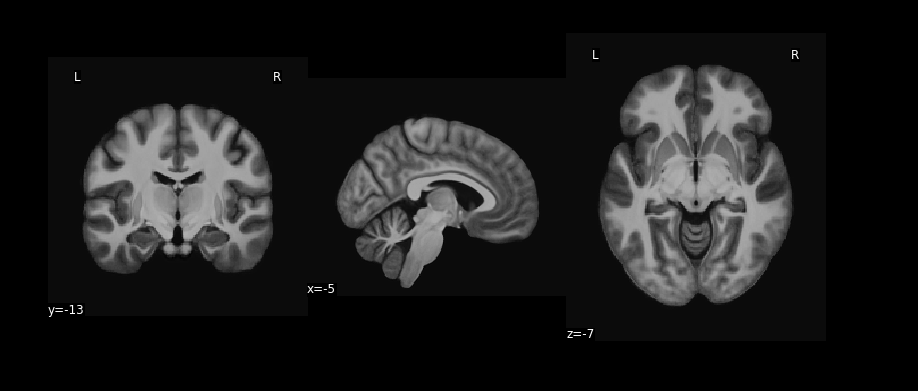

In [19]:
plotting.plot_anat(mean_img, cut_coords=[-5, -13, -7], draw_cross=False)
plt.gcf().set_size_inches(12,5)

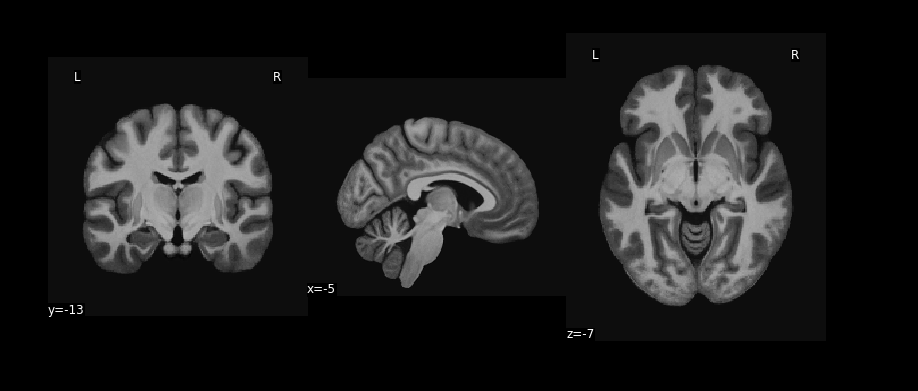

In [20]:
plotting.plot_anat(median_img, cut_coords=[-5, -13, -7], draw_cross=False)
plt.gcf().set_size_inches(12,5)

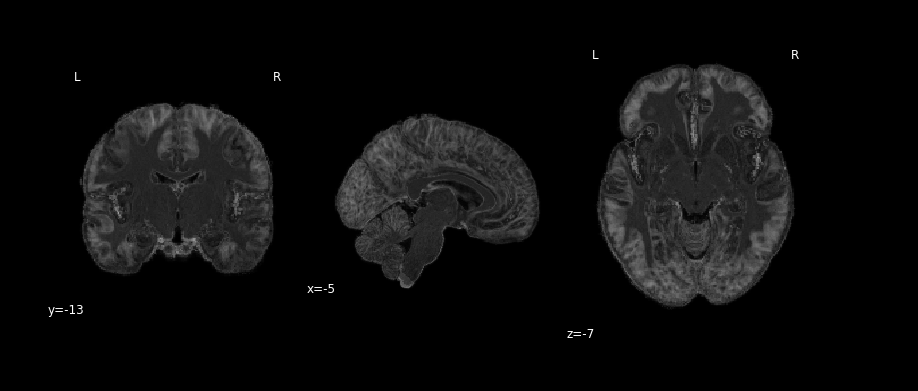

In [18]:
plotting.plot_anat(sd_img, cut_coords=[-5, -13, -7], draw_cross=False)
plt.gcf().set_size_inches(12,5)

### Register everything to the median as a new template

In [44]:
from fmriprep.utils import collect_data
from fmriprep.utils.bids import collect_participants

In [38]:
bids_dir = './data/raw/bids'
subject_id = '01'
task_id = None
collect_data(bids_dir, subject_id, task_id)

({'fmap': ['/home/neuro/work_dir/data/raw/bids/sub-01/ses-me/fmap/sub-01_ses-me_magnitude1.nii',
   '/home/neuro/work_dir/data/raw/bids/sub-01/ses-me/fmap/sub-01_ses-me_magnitude2.nii',
   '/home/neuro/work_dir/data/raw/bids/sub-01/ses-me/fmap/sub-01_ses-me_phasediff.nii',
   '/home/neuro/work_dir/data/raw/bids/sub-01/ses-se/fmap/sub-01_ses-se_magnitude1.nii',
   '/home/neuro/work_dir/data/raw/bids/sub-01/ses-se/fmap/sub-01_ses-se_magnitude2.nii',
   '/home/neuro/work_dir/data/raw/bids/sub-01/ses-se/fmap/sub-01_ses-se_phasediff.nii'],
  'bold': [['/home/neuro/work_dir/data/raw/bids/sub-01/ses-me/func/sub-01_ses-me_task-stop_run-1_echo-1_bold.nii',
    '/home/neuro/work_dir/data/raw/bids/sub-01/ses-me/func/sub-01_ses-me_task-stop_run-1_echo-2_bold.nii',
    '/home/neuro/work_dir/data/raw/bids/sub-01/ses-me/func/sub-01_ses-me_task-stop_run-1_echo-3_bold.nii'],
   ['/home/neuro/work_dir/data/raw/bids/sub-01/ses-me/func/sub-01_ses-me_task-stop_run-2_echo-1_bold.nii',
    '/home/neuro/work_

In [77]:
?embedded_antsreg

In [ ]:
prep_bids_dir = './data/deriv/fmriprep'
subject_list = collect_participants(bids_dir)

# set-up registration stuff
from nighres.registration import embedded_antsreg
# save median img as target
target_img = '/data/templates/group_median.nii.gz'
nib.save(median_img, filename='/data/templates/group_median.nii.gz')


for subject in subject_list[1:]:
    print(subject)
    fns, layout = collect_data(prep_bids_dir, subject)
    source_fn = layout.get(subject=subject, modality='anat', regex_search='*T1w_preproc.nii.gz$', type='preproc')[0].filename
    save_dir = os.path.dirname(source_fn)
    print(target_img)
    print('Will save to: %s' %save_dir)
    registration_result = embedded_antsreg(source_image=source_fn,
                                           target_image=target_img,
                                           run_rigid=True, run_affine=False, run_syn=True)
    
    nib.save(registration_result['transformed_source'], filename=os.path.join(save_dir, 'sub-%s_T1w_space-groupmedian.nii.gz' %subject))
    nib.save(registration_result['mapping'], filename=os.path.join(save_dir, 'sub-%s_T1w_space-groupmedian_mapping.nii.gz' %subject))
    nib.save(registration_result['inverse'], filename=os.path.join(save_dir, 'sub-%s_T1w_space-groupmedian_inverse.nii.gz' %subject))   

# plotting.plot_anat('data/raw/bids/sub-01/ses-me/anat/sub-01_ses-me_T1w.nii', cut_coords=[0,0,0])

In [ ]:
!ls

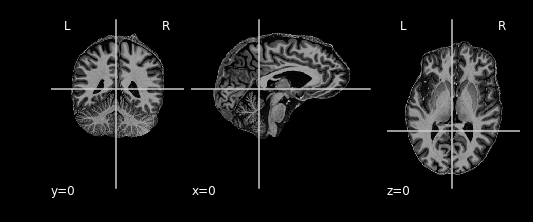

In [42]:
plotting.plot_anat('data/deriv/fmriprep/sub-01/anat/sub-01_T1w_space-groupmedian.nii.gz', cut_coords=[0,0,0])

### Let's see what the results look like again

In [90]:
!ls data/deriv/fmriprep/sub-01/anat/

sub-01_T1w_brainmask.nii.gz
sub-01_T1w_class-CSF_probtissue.nii.gz
sub-01_T1w_class-GM_probtissue.nii.gz
sub-01_T1w_class-WM_probtissue.nii.gz
sub-01_T1w_dtissue.nii.gz
sub-01_T1w_preproc.nii.gz
sub-01_T1w_space-groupmedian.nii.gz
sub-01_T1w_space-groupmedian_inverse.nii.gz
sub-01_T1w_space-groupmedian_mapping.nii.gz
sub-01_T1w_space-mni_icbm152_t1_tal_nlin_asym_09a_brain_d4mm_brainmask.nii.gz
sub-01_T1w_space-mni_icbm152_t1_tal_nlin_asym_09a_brain_d4mm_class-CSF_probtissue.nii.gz
sub-01_T1w_space-mni_icbm152_t1_tal_nlin_asym_09a_brain_d4mm_class-GM_probtissue.nii.gz
sub-01_T1w_space-mni_icbm152_t1_tal_nlin_asym_09a_brain_d4mm_class-WM_probtissue.nii.gz
sub-01_T1w_space-mni_icbm152_t1_tal_nlin_asym_09a_brain_d4mm_dtissue.nii.gz
sub-01_T1w_space-mni_icbm152_t1_tal_nlin_asym_09a_brain_d4mm_preproc.nii.gz
sub-01_T1w_space-mni_icbm152_t1_tal_nlin_asym_09a_brain_d4mm_target-T1w_warp.nii.gz
sub-01_T1w_target-mni_icbm152_t1_tal_nlin_asym_09a_brain_d4mm_warp.nii.gz


In [105]:
all_t1w = glob.glob('./data/deriv/fmriprep/sub-*/anat/sub-*_T1w_space-groupmedian.nii.gz')
all_t1w.sort()
all_t1w_4d = nib.concat_images(all_t1w)

In [106]:
default_hdr = nib.load(all_t1w[0]).affine
def to_n1i(data, affine=default_hdr):
    return nib.Nifti1Image(data, affine=affine)

In [107]:
mean_img_grpmdn = to_n1i(np.mean(all_t1w_4d.get_data(), 3))
median_img_grpmdn = to_n1i(np.median(all_t1w_4d.get_data(), 3))
sd_img_grpmdn = to_n1i(np.std(all_t1w_4d.get_data(), 3))

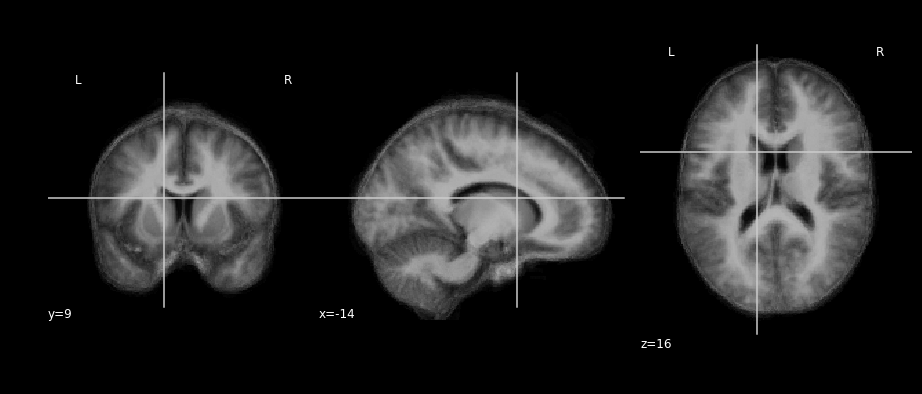

In [117]:
plotting.plot_anat(mean_img, cut_coords=[-14, 9, 16])
plt.gcf().set_size_inches(12,5)

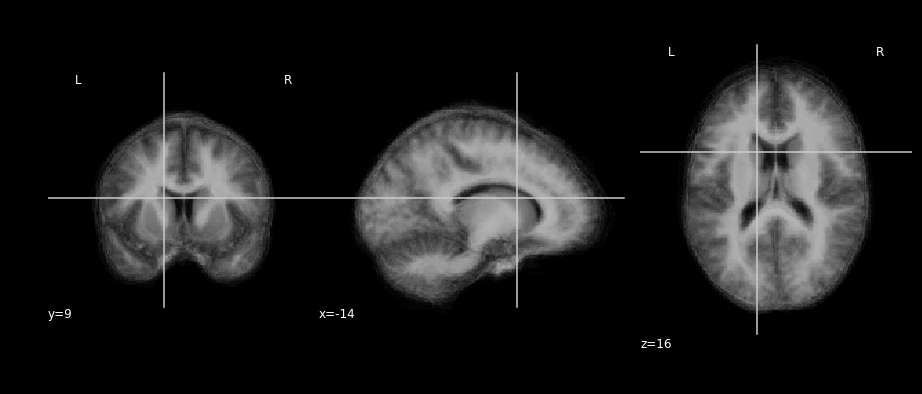

In [118]:
plotting.plot_anat(mean_img_grpmdn, cut_coords=[-14, 9, 16])
plt.gcf().set_size_inches(12,5)

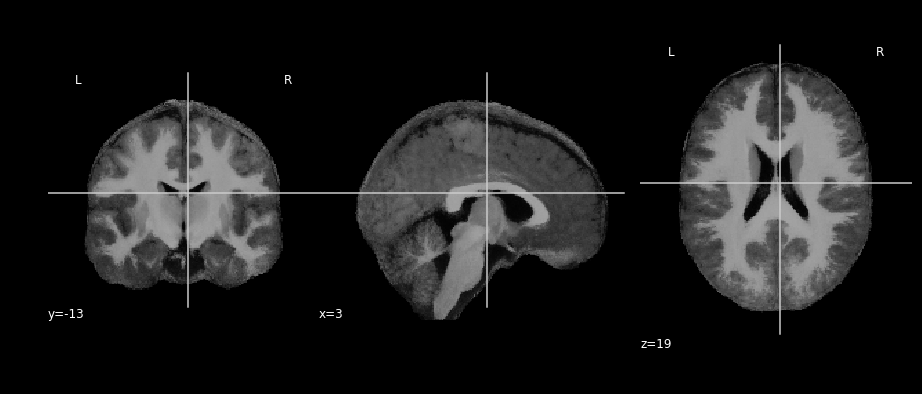

In [116]:
plotting.plot_anat(median_img)
plt.gcf().set_size_inches(12,5)

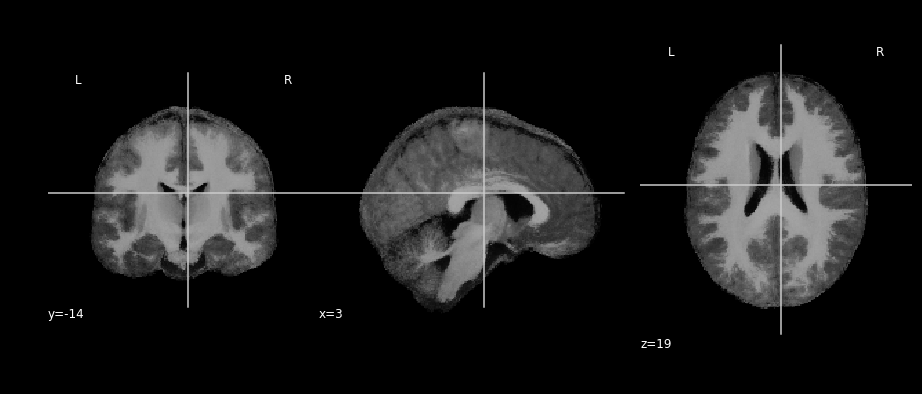

In [112]:
plotting.plot_anat(median_img_grpmdn)
plt.gcf().set_size_inches(12,5)

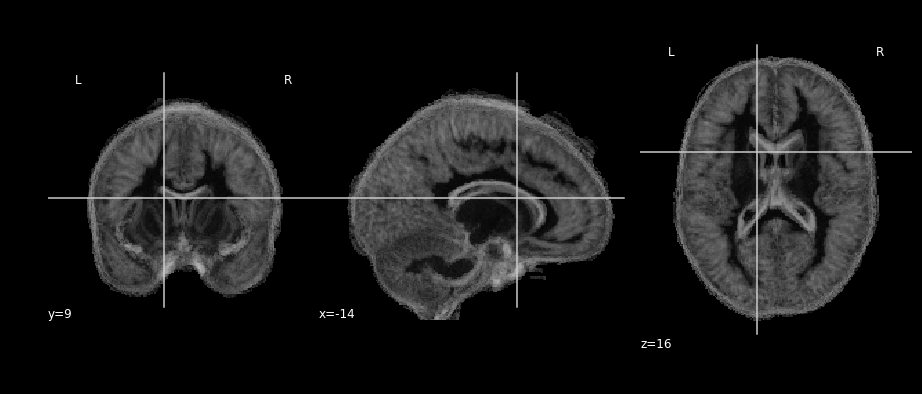

In [113]:
plotting.plot_anat(sd_img, cut_coords=[-14, 9, 16])
plt.gcf().set_size_inches(12,5)

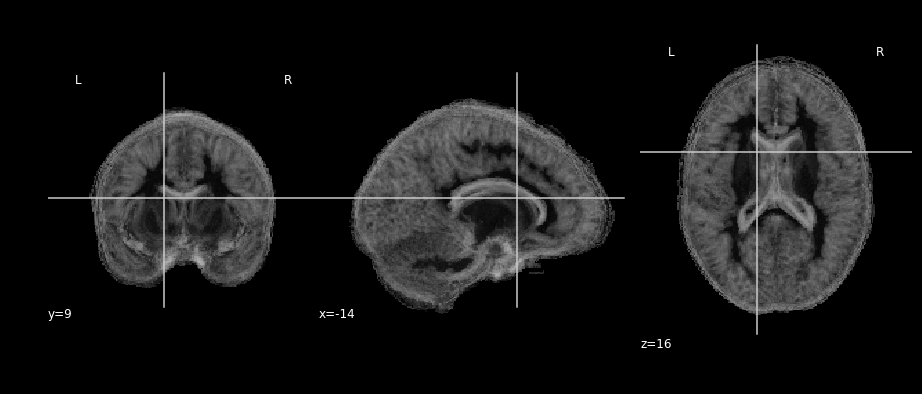

In [114]:
plotting.plot_anat(sd_img_grpmdn, cut_coords=[-14, 9, 16])
plt.gcf().set_size_inches(12,5)